In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import gzip
import random
import time
import matplotlib.pyplot as plt

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)
print('ok')

ok


In [2]:
cnt=0
for l in readGz("data/train.json.gz"):
    print(l)
    cnt+=1
    if cnt>=5:
        break

{'rating': 5.0, 'businessID': 'B408037852', 'reviewText': "This is where i go to shop for gifts from my mom. She loves this stuff. Cna't get enough. I like that you can customize the items. Store is well alid out and shoppable.", 'userID': 'U093387342', 'reviewTime': 'Mar 24, 2013', 'categories': ["Women's Clothing Store", 'Fashion Accessories Store', 'Shoe Store'], 'reviewHash': 'R471510664', 'unixReviewTime': 1364143460}
{'rating': 5.0, 'businessID': 'B410583770', 'reviewText': "Quaint, stylish atmosphere in a small place right off South Congress. The food and service were great. It's pricey, but the happy hour deals are considerable. Great for a date!", 'userID': 'U637588426', 'reviewTime': 'Sep 21, 2011', 'categories': ['Italian Restaurant', 'European Restaurant'], 'reviewHash': 'R954562590', 'unixReviewTime': 1316616175}
{'rating': 4.0, 'businessID': 'B423621081', 'reviewText': "I'm a vegetarian, but every so often I want a hotdog with lots of toppings.  And a tall can of beer.  F

In [3]:
users=[]
bussiness=[]
for l in readGz("data/train.json.gz"):
    u=l['userID']
    b=l['businessID']
    users.append(u)
    bussiness.append(b)
    
user_set=set(users)
buss_set=set(bussiness)

Nu=len(user_set)  # 18793
Nb=len(buss_set)  # 21321

user_index={}
buss_index={}

for (i,u) in enumerate(user_set):
    user_index[u]=i
for (i,b) in enumerate(buss_set):
    buss_index[b]=i
print(Nu,Nb)
print('ok')

18793 21321
ok


In [4]:
num_train=199000

user_business={}
y=np.zeros((Nu,Nb),dtype=np.bool_)

ui_val=[]
bi_val=[]
y_val=[]

i=0
for l in readGz("data/train.json.gz"):
    u=user_index[l['userID']]
    b=buss_index[l['businessID']]
    if i<num_train:
        y[u,b]=1
        if u in user_business:
            user_business[u].append(b)
        else:
            user_business[u]=[b]
    else:
        ui_val.append(u)
        bi_val.append(b)
        y_val.append(1)
    i+=1
print('ok')

ok


In [5]:
for (u,b_list) in user_business.items():
    user_business[u]=np.array(b_list)
print('ok')

ok


In [6]:
num_val=(len(users)-num_train)*2
ui_val_first=np.array(ui_val)
bi_val_first=np.array(bi_val)
ui_val_second=np.random.randint(Nu,size=(num_val//2,))
bi_val_second=np.random.randint(Nb,size=(num_val//2,))
for i in range(ui_val_second.shape[0]):
    y_val.append(bi_val_second[i] in user_business[ui_val_second[i]])
ui_val=np.concatenate((ui_val_first,ui_val_second))
bi_val=np.concatenate((bi_val_first,bi_val_second))
y_val=np.array(y_val)
print(ui_val.shape)
print(bi_val.shape)
print(np.sum(y_val))

(2000,)
(2000,)
1000


In [7]:
K=400
weight_scale=1
max_iter=5000
print_every=50
batch_size_user=3000
batch_size_buss_pair=150
learning_rate=1e-2
lamb=4e-1

def sample():
    u_index=np.random.randint(Nu,size=batch_size_user)
    b_index=[]
    for u in u_index:
        this_b_list=[]
        b0_index=np.random.choice(np.where(y[u,:]==0)[0],batch_size_buss_pair)
        b1_index=np.random.choice(np.where(y[u,:]==1)[0],batch_size_buss_pair)
        for i in range(batch_size_buss_pair):
            this_b_list.append((b0_index[i],b1_index[i]))
        b_index.append(this_b_list)
    return list(u_index),b_index

gamma_u=np.random.randn(Nu,K)*weight_scale
gamma_b=np.random.randn(Nb,K)*weight_scale

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

sample_loss_his=[]
accuracy_val_his=[]
accuracy_train_his=[]

for it in range(max_iter):
    sample_loss=0
    
    dgamma_u=np.zeros_like(gamma_u)
    dgamma_b=np.zeros_like(gamma_b)
    
    u_index,b_index=sample()
    
    for (i,u) in enumerate(u_index):
        b_list=b_index[i]
        for (b0,b1) in b_list:
            temp=sigmoid(np.inner(gamma_u[u,:],gamma_b[b1,:])-np.inner(gamma_u[u,:],gamma_b[b0,:]))
            sample_loss+=np.log(temp)
            dgamma_u[u,:]+=(1.0-temp)*(gamma_b[b1,:]-gamma_b[b0,:])
            dgamma_b[b1,:]+=(1.0-temp)*gamma_u[u,:]
            dgamma_b[b0,:]-=(1.0-temp)*gamma_u[u,:]
            
    sample_loss-=0.5*lamb*(np.sum(np.square(gamma_u))+np.sum(np.square(gamma_b)))
    dgamma_u-=lamb*gamma_u
    dgamma_b-=lamb*gamma_b
    
    gamma_u+=learning_rate*dgamma_u
    gamma_b+=learning_rate*dgamma_b
    
    sample_loss_his.append(sample_loss)
    
    if it==0 or (it+1)%print_every==0:
        accuracy_train=0
        for (i,u) in enumerate(u_index):
            b_list=b_index[i]
            for (b0,b1) in b_list:
                predict0=sigmoid(np.inner(gamma_u[u,:],gamma_b[b0,:]))>0.6
                predict1=sigmoid(np.inner(gamma_u[u,:],gamma_b[b1,:]))>0.6
                if predict0==0:
                    accuracy_train+=1
                if predict1==1:
                    accuracy_train+=1
        accuracy_train=100.0*accuracy_train/(batch_size_user*batch_size_buss_pair*2)
        accuracy_train_his.append(accuracy_train)
        accuracy_val=0
        for i in range(num_val):
            predict=sigmoid(np.inner(gamma_u[ui_val[i],:],gamma_b[bi_val[i],:]))>0.6
            if predict==y_val[i]:
                accuracy_val+=1
        accuracy_val=100.0*accuracy_val/num_val
        accuracy_val_his.append(accuracy_val)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'iter %d, sample_loss=%.10f accuracy_train=%.2f%% accuracy_val=%.2f%%' %(it+1,sample_loss,accuracy_train,accuracy_val))

2017-11-18 21:24:16 iter 1, sample_loss=-8249819.1404865477 accuracy_train=78.95% accuracy_val=51.35%
2017-11-18 21:32:57 iter 50, sample_loss=-2389352.7110240590 accuracy_train=75.56% accuracy_val=51.60%
2017-11-18 21:41:54 iter 100, sample_loss=-1590587.6192620203 accuracy_train=75.85% accuracy_val=52.20%
2017-11-18 21:50:51 iter 150, sample_loss=-1063988.6934024764 accuracy_train=76.28% accuracy_val=51.95%
2017-11-18 21:59:46 iter 200, sample_loss=-712805.4245873404 accuracy_train=76.88% accuracy_val=52.10%
2017-11-18 22:08:43 iter 250, sample_loss=-478333.1360757722 accuracy_train=77.88% accuracy_val=52.15%
2017-11-18 22:17:43 iter 300, sample_loss=-323187.4435247226 accuracy_train=79.21% accuracy_val=52.95%
2017-11-18 22:26:26 iter 350, sample_loss=-221832.5611661528 accuracy_train=81.06% accuracy_val=53.40%
2017-11-18 22:35:33 iter 400, sample_loss=-157868.7571376158 accuracy_train=83.61% accuracy_val=56.10%
2017-11-18 22:45:05 iter 450, sample_loss=-118492.3775910341 accuracy_tr

2017-11-19 08:34:59 iter 4000, sample_loss=-46506.7419381075 accuracy_train=94.35% accuracy_val=90.65%
2017-11-19 08:43:24 iter 4050, sample_loss=-46740.8942259956 accuracy_train=94.32% accuracy_val=90.55%
2017-11-19 08:51:48 iter 4100, sample_loss=-46568.8441832478 accuracy_train=94.31% accuracy_val=90.60%
2017-11-19 09:00:12 iter 4150, sample_loss=-46735.7986326038 accuracy_train=94.38% accuracy_val=90.75%
2017-11-19 09:08:37 iter 4200, sample_loss=-46622.1786766682 accuracy_train=94.35% accuracy_val=90.70%
2017-11-19 09:17:03 iter 4250, sample_loss=-46588.4656887142 accuracy_train=94.29% accuracy_val=90.80%
2017-11-19 09:25:43 iter 4300, sample_loss=-46638.5695391961 accuracy_train=94.26% accuracy_val=90.65%
2017-11-19 09:34:08 iter 4350, sample_loss=-46565.5550355831 accuracy_train=94.38% accuracy_val=90.80%
2017-11-19 09:42:33 iter 4400, sample_loss=-46540.9476576366 accuracy_train=94.35% accuracy_val=90.65%
2017-11-19 09:50:59 iter 4450, sample_loss=-46421.0817399522 accuracy_tra

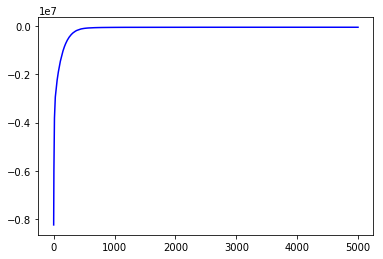

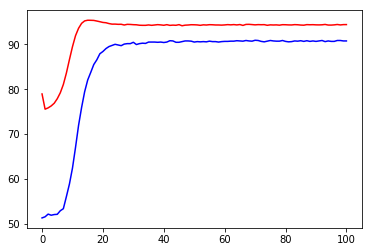

In [8]:
plt.plot(range(max_iter),sample_loss_his,'b-')
plt.show()
plt.plot(range(max_iter//print_every+1),accuracy_train_his,'r-')
plt.plot(range(max_iter//print_every+1),accuracy_val_his,'b-')
plt.show()

In [9]:
print(gamma_u)
print(gamma_b)
def predict_y(u,b):
    print(sigmoid(np.inner(gamma_u[u,:],gamma_b[b,:])))
    return sigmoid(np.inner(gamma_u[u,:],gamma_b[b,:]))>0.5

print(predict_y(user_index['U093387342'],buss_index['B408037852']))  # train +
print(predict_y(user_index['U093387342'],buss_index['B410583770']))  # train -
print(predict_y(user_index['U732361363'],buss_index['B105995104']))  # test

[[ 0.03935571  0.07596732 -0.13449681 ...,  0.04236134 -0.11140343
   0.22559213]
 [-0.18270476 -0.19536961  0.17281223 ...,  0.1552453  -0.07556583
  -0.04181209]
 [-0.05692413 -0.13063943 -0.11850363 ..., -0.02851646 -0.03375666
  -0.11701158]
 ..., 
 [ 0.19687745 -0.02532594  0.02156703 ...,  0.09054881  0.08213591
   0.04613953]
 [-0.01148138 -0.01266552  0.10373824 ...,  0.07840855  0.06748617
  -0.04859549]
 [-0.06841165 -0.06678253  0.07951745 ..., -0.10159582  0.14029304
  -0.05189093]]
[[ 0.0009302  -0.13140983  0.09188073 ...,  0.06935012  0.04181022
   0.19664496]
 [ 0.06144654  0.17820036 -0.24821427 ..., -0.16790058 -0.01244722
   0.07641156]
 [ 0.09135474 -0.07018373  0.09686894 ...,  0.26121721 -0.16186866
  -0.17257873]
 ..., 
 [-0.08028667 -0.03127641 -0.16883885 ..., -0.00302034  0.07732866
  -0.2613917 ]
 [ 0.17593689 -0.18778326 -0.12594109 ...,  0.09860601  0.0385617
  -0.00853858]
 [-0.0187856   0.0420347   0.06458524 ..., -0.05068514 -0.02598905
   0.08535397]]
0

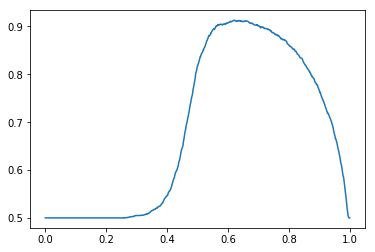

best bound = 0.619 max accuracy = 0.913


In [10]:
bound_list=np.linspace(0,1,1001)
accuracy_his=[]
max_accuracy=-1
best_bound=-1
for bound in bound_list:
    accuracy=0
    for i in range(num_val):
        predict=sigmoid(np.inner(gamma_u[ui_val[i],:],gamma_b[bi_val[i],:]))>bound
        accuracy+=1 if predict==y_val[i] else 0
    accuracy/=num_val
    if accuracy>max_accuracy:
        max_accuracy=accuracy
        best_bound=bound
    accuracy_his.append(accuracy)
plt.plot(bound_list,np.array(accuracy_his))
plt.show()
print('best bound =',best_bound,'max accuracy =',max_accuracy)

In [11]:
true_pos=0
true_neg=0
false_pos=0
false_neg=0

for i in range(num_val):
    ui=ui_val[i]
    bi=bi_val[i]
    real=y_val[i]
    
    predict=sigmoid(np.inner(gamma_u[ui,:],gamma_b[bi,:]))>best_bound
        
    if predict==1 and real==1:
        true_pos+=1
    elif predict==1 and real==0:
        false_pos+=1
    elif predict==0 and real==1:
        false_neg+=1
    elif predict==0 and real==0:
        true_neg+=1
print('accuracy =',(true_pos+true_neg)/num_val)
print('true pos =',true_pos)
print('false pos =',false_pos)
print('false neg =',false_neg)
print('true neg=',true_neg)
pp=true_pos/(true_pos+false_pos)
rr=true_pos/(true_pos+false_neg)
print('F1 =',(2.0*pp*rr)/(pp+rr))

accuracy = 0.913
true pos = 926
false pos = 100
false neg = 74
true neg= 900
F1 = 0.914116485686081


In [12]:
test_file=open('data/pairs_Visit.txt')
fo=open('data/pairs_Visit_out_4.txt','w')
fo.write('userID-businessID,prediction\n')
c1=0
c2=0
c3=0
for line in test_file:
    if line == 'userID-businessID,prediction\n':
        continue
    [u,b]=line.strip().split('-')
    if u not in user_index or b not in buss_index:
        predict=random.randint(0,1)
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c1+=1
    else:
        ui=user_index[u]
        bi=buss_index[b]

        predict=sigmoid(np.inner(gamma_u[ui,:],gamma_b[bi,:]))>best_bound
                
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c3+=1
fo.close()
print(c1,c2,c3)

63 0 39937
